# Examine

## Imports and Globals

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from pathlib import Path
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split

In [2]:
# Globals
SEED = 22
start_time = time.time()

## Load data

In [3]:
data_dir = Path("../data/cleaned")
years = [2022, 2023]

dfs = []
for year in years:
    file = data_dir / f"brfss_cleaned_{year}.csv"
    print(f"Loading {file}")
    df = pd.read_csv(file)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Merged shape: {df_all.shape}")
df.head()

Loading ../data/cleaned/brfss_cleaned_2022.csv
Loading ../data/cleaned/brfss_cleaned_2023.csv
Merged shape: (876384, 12)


,year,age,sex,educa,bmi,bmi_cat,drink_any,snap_used,food_insecurity,smoke_100,exercise_any,diabetes
0,2023,85.0,Female,Some college,30.47,Obese,No,No,Never,No,No,Yes
1,2023,85.0,Female,Some college,28.56,Overweight,No,No,Never,No,Yes,No
2,2023,85.0,Female,HS or GED,22.31,Normal,No,No,Never,Yes,Yes,No
3,2023,77.0,Female,Some college,27.44,Overweight,No,No,Never,No,Yes,No
4,2023,77.0,Female,Some college,25.85,Overweight,Yes,No,Rarely,No,Yes,Yes


## Quick EDA

In [4]:
# # Check target class balance
# print(df_all["diabetes"].value_counts())
# print(df_all["diabetes"].value_counts(normalize=True))

In [5]:
# # Count by year
# print(df_all.groupby("year")["diabetes"].value_counts(normalize=True))

In [6]:
# sns.countplot(data=df_all, x="year", hue="diabetes")
# plt.title("Diabetes prevalence by year")
# plt.show()

## Baseline model

### Preprocessing

In [7]:
df_model = df_all.copy()

# Features and target
features = [
    "year", "age", "sex", "educa", "bmi", "bmi_cat", "drink_any", "snap_used",
    "food_insecurity", "smoke_100", "exercise_any"
]

target = "diabetes"

df_model = df_model[features + [target]].copy()


### Convert binary and categorical vars
binary_cols = ["smoke_100", "exercise_any", "diabetes", "drink_any", "snap_used"]
for col in binary_cols:
    df_model[col] = df_model[col].astype(str).str.strip().str.replace('"', '').map({"Yes": 1, "No": 0})

In [8]:
### Convert categorical strings to dummy vars
df_model = pd.get_dummies(df_model, columns=["sex", "educa", "bmi_cat", 
                                             "food_insecurity"], drop_first=True)

print(df_model.columns.tolist())
print("Any NaNs in X?", df_model.drop(columns=["diabetes"]).isna().any().any())
df_model.head()

['year', 'age', 'bmi', 'drink_any', 'snap_used', 'smoke_100', 'exercise_any', 'diabetes', 'sex_Male', 'educa_HS or GED', 'educa_Less than HS', 'educa_Some college', 'bmi_cat_Obese', 'bmi_cat_Overweight', 'bmi_cat_Underweight', 'food_insecurity_Never', 'food_insecurity_Rarely', 'food_insecurity_Sometimes', 'food_insecurity_Usually']
Any NaNs in X? True


,year,age,bmi,drink_any,snap_used,smoke_100,exercise_any,diabetes,sex_Male,educa_HS or GED,educa_Less than HS,educa_Some college,bmi_cat_Obese,bmi_cat_Overweight,bmi_cat_Underweight,food_insecurity_Never,food_insecurity_Rarely,food_insecurity_Sometimes,food_insecurity_Usually
0,2022,85.0,NaN,0.0,0.0,0.0,0.0,1,False,False,False,False,False,False,False,True,False,False,False
1,2022,85.0,26.57,0.0,0.0,0.0,0.0,0,False,True,False,False,False,True,False,True,False,False,False
2,2022,57.0,25.61,0.0,0.0,0.0,1.0,0,False,False,False,False,False,True,False,True,False,False,False
3,2022,NaN,23.30,0.0,0.0,1.0,1.0,0,False,True,False,False,False,False,False,True,False,False,False
4,2022,42.0,21.77,1.0,0.0,0.0,1.0,0,False,False,False,True,False,False,False,True,False,False,False


In [9]:
print("Before split:", df_model.shape)

features = [f for f in features if f in df_model.columns]
# Drop rows with missing values in selected features or target
df_model = df_model.dropna(subset=features + [target])

print("After dropping NA:", df_model.shape)

Before split: (876384, 19)
After dropping NA: (433342, 19)


In [10]:
# Split features and target
X = df_model.drop(columns=["diabetes"])
y = df_model["diabetes"]

## Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print(X_train.shape, X_test.shape)

(346673, 18) (86669, 18)


## Baseline Model

In [12]:
neg, pos = np.bincount(y_train)
print(f"Negative: {neg}, positive: {pos}")
scale = neg / pos
print(f"Negative: {neg}, positive: {pos}, scale: {scale:.2f}")

model = xgb.XGBClassifier(
    # use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=SEED
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

Negative: 294947, positive: 51726
Negative: 294947, positive: 51726, scale: 5.70
y_test shape: (86669,)
y_pred shape: (86669,)


## Evaluation

In [13]:
print("\nClassification Report(Baseline XGBoost):")
print(classification_report(y_test, y_pred, digits=3))


Classification Report(Baseline XGBoost):
              precision    recall  f1-score   support

           0      0.936     0.658     0.773     73738
           1      0.276     0.742     0.402     12931

    accuracy                          0.671     86669
   macro avg      0.606     0.700     0.588     86669
weighted avg      0.837     0.671     0.718     86669



### Visualizations

In [14]:
# y_true = df_model["diabetes"]
# y_probs = model.predict_proba(X)[:, 1]

# # ROC Curve
# fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)
# roc_auc = roc_auc_score(y_true, y_probs)

# plt.figure()
# plt.plot(fpr, tpr, label=f"AUC + {roc_auc:.2f}")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate (Recall)")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [15]:
print(classification_report(y_test, y_pred, digits=3))
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

              precision    recall  f1-score   support

           0      0.936     0.658     0.773     73738
           1      0.276     0.742     0.402     12931

    accuracy                          0.671     86669
   macro avg      0.606     0.700     0.588     86669
weighted avg      0.837     0.671     0.718     86669

y_test shape: (86669,)
y_pred shape: (86669,)


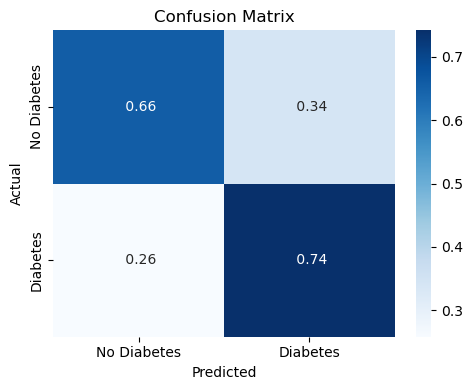

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt=" .2f", cmap="Blues",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues", values_format=".2f")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.grid(False)
plt.savefig("../reports/xgboost_confusion_matrix.png")
plt.show()

y_probs shape: (86669,)
y_test shape: (86669,)


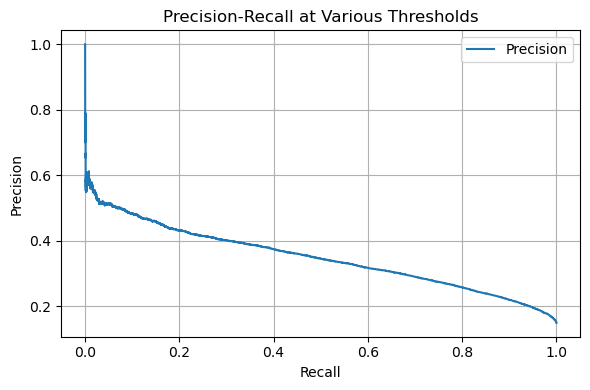

In [17]:
# Get predicted probabilities for the positve class (diabetes)
y_probs = model.predict_proba(X_test)[:, 1]

print(f"y_probs shape: {y_probs.shape}")
print(f"y_test shape: {y_test.shape}")

# # Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall at Various Thresholds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# # Threshold tuning table
# threshold_data = pd.DataFrame({
#     "threshold": thresholds_pr,
#     "precision": precision[:-1],
#     "recall": recall[:-1]
# })

# threshold_data.head(20)

In [19]:
# precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_true, y_probs)

# threshold_data = pd.DataFrame({
#     "threshold": thresholds_pr,
#     "precision": precision_vals[:-1],
#     "recall": recall_vals[:-1]
# })

# # Filter to better tradeoffs
# threshold_data_filtered = threshold_data[
#     (threshold_data["precision"] > 0.3) & (threshold_data["recall"] > 0.4)
# ].reset_index(drop=True)

# threshold_data_filtered.head(20)

In [20]:
# threshold = 0.59285
# y_pred_thresh = (y_probs >= threshold).astype(int)

# print(f"Threshold: {threshold}")
# print(classification_report(y_true, y_pred_thresh))

# # Show confusion matrix
# cm = confusion_matrix(y_true, y_pred_thresh, normalize="true")
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues", values_format=".2f")
# plt.title(f"Confusion Matrix at Threshold = {threshold:.5f}")
# plt.grid(False)
# plt.show()

## End

In [21]:
time_spent = (time.time() - start_time) / 60 

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 0.08 minutes
